In [15]:
#import all packages needed
import torch
torch.set_default_dtype(torch.float64) #keep more precision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import os
import math

%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
import random

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from numpy import genfromtxt

from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from numpy import arcsinh as arcsinh
from torchvision import models
from pathlib import Path
from tqdm import tqdm
from astropy.visualization import make_lupton_rgb
import pandas as pd
from functools import partial
print(torch.__version__)

2.0.0.post200


In [5]:
#fix seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(0)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Dataset

In [13]:
#visualize data helper function
def visualize(X,ind):
  '''
  X: image numpy array
  ind: list of indexes
  '''
  fig1=plt.figure(figsize=(8,8))

  for i in range(16):
      plt.subplot(4, 4, i + 1)
      plt.axis("off")
      example_indices = int(ind[i])
      example_image = np.squeeze(X[example_indices:(example_indices + 1), 0:1]) #change band by switching 0:1 to 1:2 or 2:3
      plt.imshow(example_image, aspect='auto', cmap='viridis')
      
# Define data visualization function
def visualize_data(data):
    '''
    visualizes 16 random images from dataset
    '''
    
    data_length = len(data)
    num_indices = 16
    
    # Generate 15 unique random indices using numpy
    random_indices = np.random.choice(data_length, size=num_indices, replace=False)

    #plot the examples for source
    fig1=plt.figure(figsize=(8,8))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.axis("off")

        img = data[random_indices[i]]
        example_image = make_lupton_rgb(img[0], img[1], img[2]) #change band by switching 0:1 to 1:2 or 2:3

        plt.imshow(example_image, aspect='auto', cmap='viridis')

In [8]:
# Load data function
def create_dataloader(img_path, metadata_path, batch_size):
    '''
    Creates dataloader for training, reserving the last 10% images for validation/testing
    '''
    data = np.load(img_path).squeeze()
    length = len(data)
    data_train = torch.tensor(data[:int(.7*length)]) # 70% train
    data_test = torch.tensor(data[int(.7*length):int(.9*length)]) # 20% test
    data_val = torch.tensor(data[int(.9*length):]) # 10% validation

    metadata = pd.read_csv(metadata_path)
    labels = metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()
    labels_train = torch.tensor(labels[:int(.7*length)])
    labels_test = torch.tensor(labels[int(.7*length):int(.9*length)])
    labels_val = torch.tensor(labels[int(.9*length):])

    data_train.cuda()
    data_test.cuda()
    data_val.cuda()
    labels_train.cuda()
    labels_test.cuda()
    labels_val.cuda()

    train_dataset = TensorDataset(data_train, labels_train)
    test_dataset = TensorDataset(data_test, labels_test)
    val_dataset = TensorDataset(data_val, labels_val)

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader, val_dataloader, data

In [12]:
# Load in data
head = Path.cwd().parents[2]
source_img_path = head / 'data/mb_source/mb_source.npy'
target_img_path = head / 'data/mb_target/mb_target.npy'
source_meta = head / 'data/mb_source/mb_source_metadata.csv'
target_meta = head / 'data/mb_target/mb_target_metadata.csv'
metadata_source = pd.read_csv(source_meta)
metadata_target = pd.read_csv(target_meta)

batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

Y_source = metadata_source['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()
Y_target = metadata_target['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()

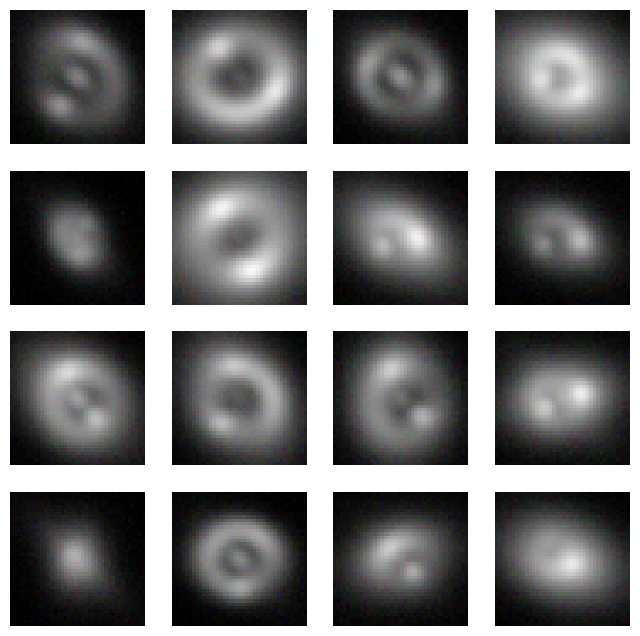

In [16]:
visualize_data(source_data)

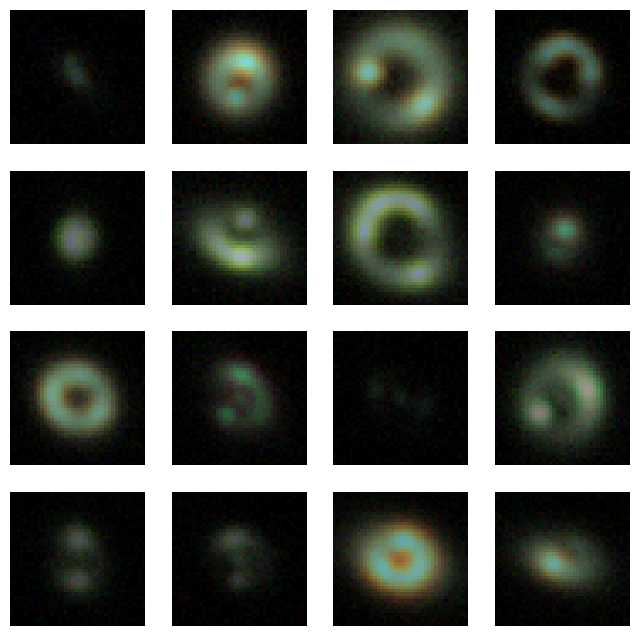

In [17]:
visualize_data(target_data)

CNN

In [32]:
class NoDANeuralNetwork(nn.Module):
    def __init__(self):
        super(NoDANeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=32*5*5, out_features=120)
        self.fc2 = nn.Linear(120, 1)

    def forward(self, x):
        x = x.view(-1, 3, 40, 40)

        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))

        x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1)
        return x

NoDAmodel = NoDANeuralNetwork().float()
NoDAmodel = NoDAmodel.cuda()

#summary(NoDAmodel, (1, 40, 40));

No DA training

In [33]:
def get_score(dataloader, model):
    score_list = np.array([])

    with torch.no_grad():
        for X, y in dataloader:
            X = X.float()
            y = y.float()
            pred = model(X.cuda())

            score = r2_score(y.cpu(), pred.cpu())
            score_list = np.append(score_list, score)

    score = np.mean(score_list)

    return score

In [37]:
def train (model, epoch, optimizer, loss_fn, trainloader, validloader):
  train_loss_ls=[]
  valid_loss_ls=[]
  score_ls=[]
  for e in range (epoch):
    model.train()
    train_loss = 0.0
    for batch, (X, y) in enumerate(trainloader):
      # Compute prediction and loss
      X = X.float()
      y = y.float()
      pred = model(X.cuda())

      loss = loss_fn(pred, y.cuda())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    valid_loss = 0.0
    model.eval()
    for batch, (X, y) in enumerate(validloader):
      X = X.float()
      y = y.float()
      pred = model(X.cuda())

      loss = loss_fn(pred, y.cuda())
      valid_loss += loss.item()

    train_loss = train_loss/ len(trainloader)
    valid_loss = valid_loss / len(validloader)
    score = get_score(trainloader, model)
    train_loss_ls.append(train_loss)
    valid_loss_ls.append(valid_loss)
    score_ls.append(score)
    print(f'Epoch {e+1} \t Training Loss: {train_loss} \t Validation Loss: {valid_loss} \t r2score: {score}')
  return train_loss_ls, valid_loss_ls, score_ls

In [38]:
#hyperparameters
loss_fn = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(NoDAmodel.parameters(), lr=1e-5)
epoch=40

In [39]:
train_loss, valid_loss, score_ls = train(NoDAmodel, epoch, optimizer,loss_fn, source_train_dataloader, source_val_dataloader)

Epoch 1 	 Training Loss: 0.07399168998425251 	 Validation Loss: 0.05134084309409758 	 r2score: 0.8958577200266746
Epoch 2 	 Training Loss: 0.04215921900938291 	 Validation Loss: 0.031350336980762755 	 r2score: 0.9366866848967248
Epoch 3 	 Training Loss: 0.029637136039455204 	 Validation Loss: 0.02544424636586077 	 r2score: 0.94863916802864
Epoch 4 	 Training Loss: 0.02266798524945375 	 Validation Loss: 0.02281949617514375 	 r2score: 0.9544366195013287
Epoch 5 	 Training Loss: 0.018600192547978414 	 Validation Loss: 0.018286955961067775 	 r2score: 0.9638149298015988
Epoch 6 	 Training Loss: 0.015733676807617794 	 Validation Loss: 0.02252951568692543 	 r2score: 0.9552096534166881
Epoch 7 	 Training Loss: 0.013619633927818736 	 Validation Loss: 0.013171371597511942 	 r2score: 0.9749896082766448
Epoch 8 	 Training Loss: 0.012249253280980128 	 Validation Loss: 0.04339126675466823 	 r2score: 0.9133419483294668
Epoch 9 	 Training Loss: 0.011251857164154132 	 Validation Loss: 0.015726659900752

In [62]:
def test(test_dataloader, model, title):
    preds = np.array([])
    true = np.array([])
    score_list=[]
    with torch.no_grad():
      for X, y in test_dataloader:
          X = X.float()
          pred = model(X.cuda())
          preds = np.append(preds, pred.cpu())
          true = np.append(true, y.cpu())
          score = r2_score(y.cpu(), pred.cpu())
          score_list = np.append(score_list, score)
    
    plt.figure(figsize=(8,8),dpi=50)
    plt.scatter(true, preds,  color='black', alpha = 0.1)
    line = np.linspace(0, 4, 100)
    plt.plot(line, line)
    plt.xlabel('True Theta E')
    plt.ylabel('Predicted Theta E');
    plt.rc('font', size=20)
    plt.title(title + '{0:.2f}'.format(np.mean(score_list)))

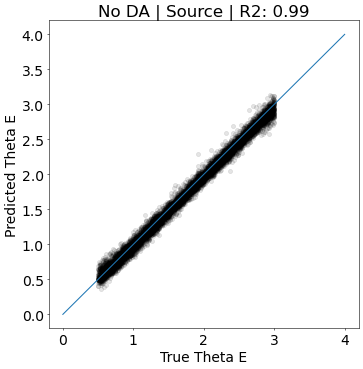

In [63]:
#test on source data
test(source_test_dataloader, NoDAmodel, 'No DA | Source | R2: ')

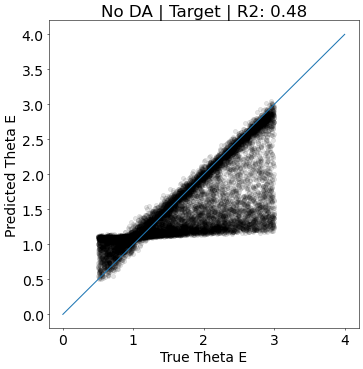

In [64]:
#test on target data
test(target_test_dataloader, NoDAmodel, 'No DA | Target | R2: ')